# Covid-19: TSA for incidence of new cases Cuba

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # plots
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

## Loading data

In [2]:
country = 'Cuba'
oper_file_path1 = 'data/cuba_data.csv'
df_input = pd.read_csv(oper_file_path1, sep=',', decimal='.', error_bad_lines=False, parse_dates=['date'])
df_input.index = df_input['date']
df_input.tail()

,date,new_cases,confirmed
date,,,
2020-04-23,2020-04-23,50,1285
2020-04-24,2020-04-24,52,1337
2020-04-25,2020-04-25,32,1369
2020-04-26,2020-04-26,20,1389
2020-04-27,2020-04-27,48,1437


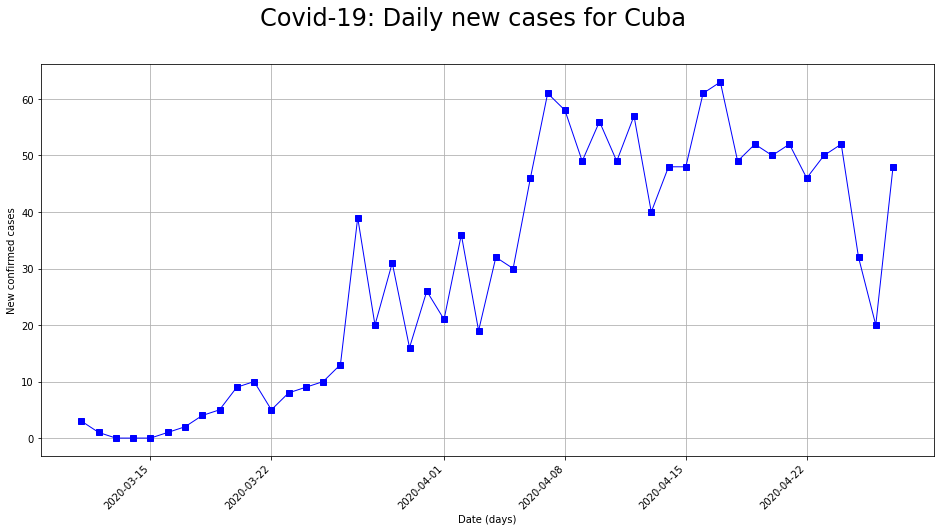

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
plt.suptitle('Covid-19: Daily new cases for {}'.format(country), fontsize=24)
plt.plot(df_input['date'], df_input['new_cases'], 'b', marker='s', ls='-', lw=1, label='Observed data')
ax.set(xlabel='Date (days)')
ax.set(ylabel='New confirmed cases')
fig.autofmt_xdate(rotation=45)
plt.grid(True)
plt.show()

## Split data into: train and test

            new_cases
date                 
2020-04-20         50
2020-04-21         52
2020-04-22         46
2020-04-23         50
2020-04-24         52
            new_cases
date                 
2020-04-25         32
2020-04-26         20
2020-04-27         48


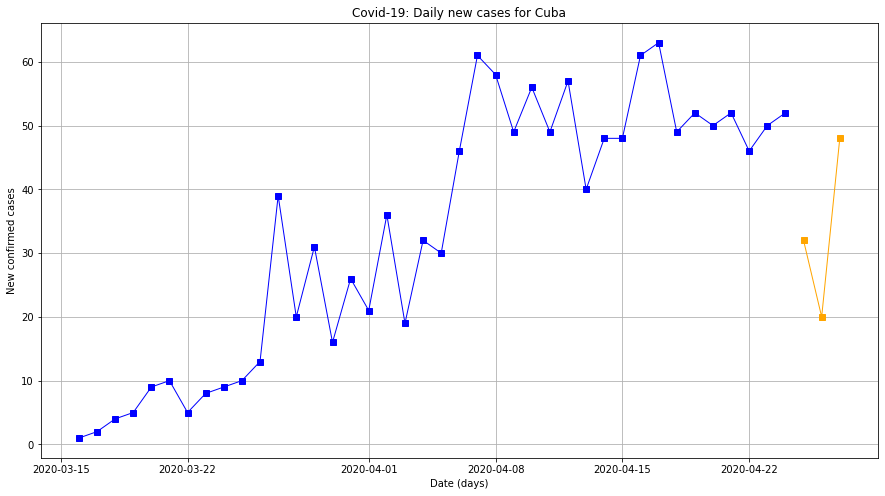

In [11]:
df_train = df_input.loc['2020-03-16':'2020-04-24'][['new_cases']]
print(df_train.tail())
df_test = df_input.loc['2020-04-25':][['new_cases']]
print(df_test)
plt.figure(figsize=(15, 8))
plt.plot(df_train.index, df_train['new_cases'], 'b', marker='s', ls='-', lw=1, label='Train')
plt.plot(df_test.index, df_test['new_cases'], 'orange', marker='s', ls='-', lw=1, label='Test')
plt.title('Covid-19: Daily new cases for {}'.format(country))
plt.xlabel('Date (days)')
plt.ylabel('New confirmed cases')
plt.grid(True)
plt.show()

## Dickey-Fuller test, ACF and PACF

/home/jrd/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


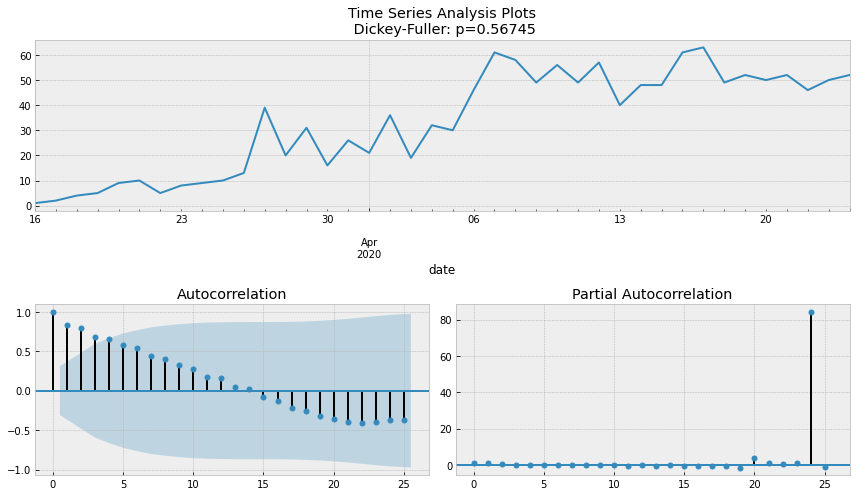

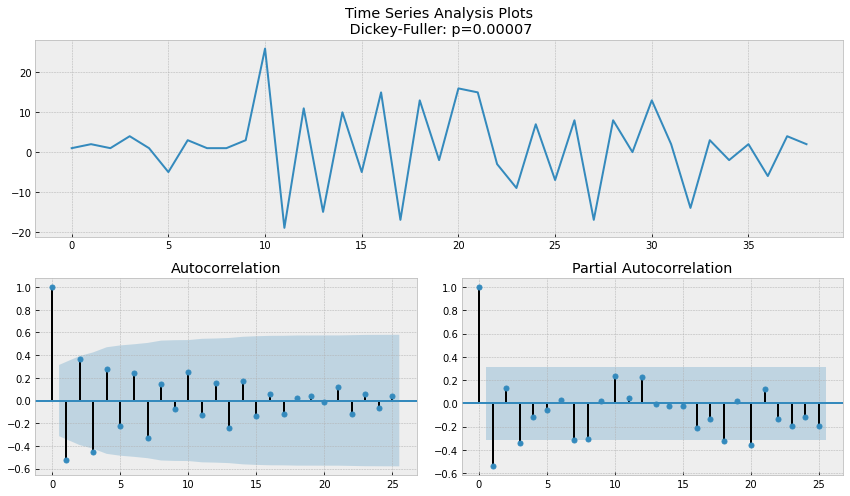

/home/jrd/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


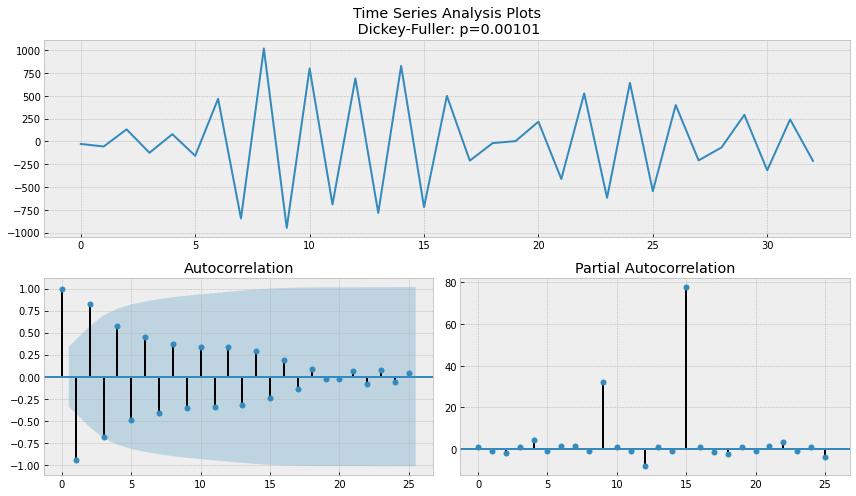

In [12]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        plt.show()
        
tsplot(df_train.new_cases, lags=25)
tsplot(np.diff(df_train.new_cases), lags=25)
tsplot(np.diff(df_train.new_cases,7), lags=25)

## Model fitting: ExponentialSmoothing and SARIMAX

Holt_Winter_add_add-rmse: 20.946511342643326
Holt_Winter_add_mul-rmse: 45.10027169913091
Holt_Winter_mul_mul-rmse: 17.99967347541259
SARIMA-rmse: 21.963732794713195


/home/jrd/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/jrd/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/jrd/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/jrd/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


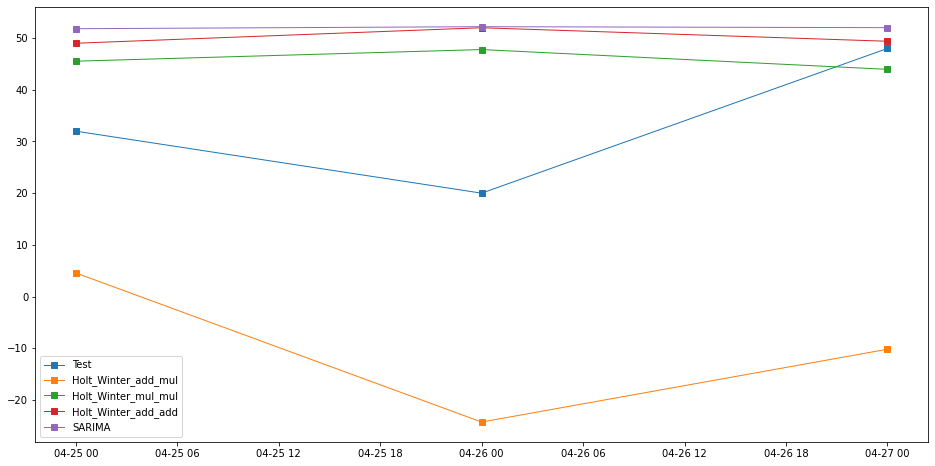

In [15]:
ylab = 'new_cases'
y_hat_avg = df_test.copy()
# y_hat_avg['log_count'] = np.log(df_test.Count)
fit1 = ExponentialSmoothing(np.asarray(df_train[ylab]), seasonal_periods=7, trend='add', seasonal='add', ).fit()
y_hat_avg['Holt_Winter_add_add'] = fit1.forecast(len(df_test))
rms = np.sqrt(mean_squared_error(y_hat_avg[ylab], y_hat_avg['Holt_Winter_add_add']))
print('Holt_Winter_add_add-rmse:',rms)

fit2 = ExponentialSmoothing(np.asarray(df_train[ylab]), seasonal_periods=7, trend='add', seasonal='mul', ).fit()
y_hat_avg['Holt_Winter_add_mul'] = fit2.forecast(len(df_test))
rms2 = np.sqrt(mean_squared_error(y_hat_avg[ylab], y_hat_avg['Holt_Winter_add_mul']))
print('Holt_Winter_add_mul-rmse:',rms2)

fit3 = ExponentialSmoothing(np.asarray(df_train[ylab]), seasonal_periods=7, trend='mul', seasonal='mul', ).fit()
y_hat_avg['Holt_Winter_mul_mul'] = fit3.forecast(len(df_test))
rms3 = np.sqrt(mean_squared_error(y_hat_avg[ylab], y_hat_avg['Holt_Winter_mul_mul']))
print('Holt_Winter_mul_mul-rmse:',rms3)

fit4 = sm.tsa.statespace.SARIMAX(df_train[ylab], order=(2, 1, 0), seasonal_order=(0, 0, 0, 7)).fit(disp=-1)
y_hat_avg['SARIMA'] = fit4.forecast(steps=len(df_test))
rms4 = np.sqrt(mean_squared_error(y_hat_avg[ylab], y_hat_avg.SARIMA))
print('SARIMA-rmse:', rms4)

plt.figure(figsize=(16, 8))
plt.plot(y_hat_avg.index, y_hat_avg[ylab], marker='s', ls='-', lw=1, label='Test')
plt.plot(y_hat_avg.index, y_hat_avg['Holt_Winter_add_mul'], marker='s', ls='-', lw=1, label='Holt_Winter_add_mul')
plt.plot(y_hat_avg.index, y_hat_avg['Holt_Winter_mul_mul'], marker='s', ls='-', lw=1, label='Holt_Winter_mul_mul')
plt.plot(y_hat_avg.index, y_hat_avg['Holt_Winter_add_add'], marker='s', ls='-', lw=1, label='Holt_Winter_add_add')
plt.plot(y_hat_avg['SARIMA'], marker='s', ls='-', lw=1, label='SARIMA')
plt.legend(loc='best')
plt.show()

### Model summary

In [8]:
model_result = fit4
res = model_result.summary()
print(res)

                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                   34
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -124.518
Date:                Tue, 28 Apr 2020   AIC                            257.036
Time:                        22:37:07   BIC                            263.142
Sample:                    03-16-2020   HQIC                           259.118
                         - 04-18-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5855      0.216      2.705      0.007       0.161       1.010
ar.L2          0.5700      0.221      2.582      0.010       0.137       1.003
ar.L3         -0.1809      0.238     -0.758      0.4

### Diagnostic plot

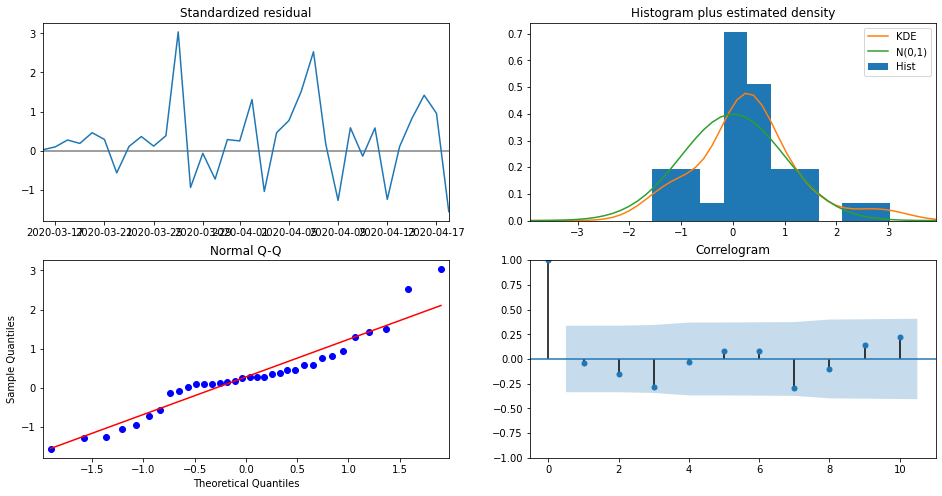

In [9]:
model_result.plot_diagnostics(figsize=(16, 8))
plt.show()

### Plot predictions of the best model (SARIMAX)

In [10]:
# Construct the forecasts
fit = fit4
fcast = fit.get_forecast(steps=7).summary_frame()
model_name = res.tables[0].data[1][1]
rms_train = round(np.sqrt(mean_squared_error(df_train[ylab], fit.fittedvalues)),2)
rms_test = round(np.sqrt(mean_squared_error(df_test[ylab], fcast['mean'][:len(df_test)])),2)
# Plot the forecasts
plt.figure(figsize=(15, 8), dpi=300)
plt.plot(df_train.index, df_train['new_cases'], 'b', marker='s', ls='-', lw=1, label='Train')
plt.plot(df_test.index, df_test['new_cases'], 'b', marker='s', ls=':', lw=1, label='Test')
plt.plot(df_train.index, fit.fittedvalues, 'g', marker='>', ls='-', lw=1, label='Fitted')
plt.plot(fcast.index,fcast['mean'], 'g',marker='>', ls=':', lw=1, label='Predicted')
plt.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='g', alpha=0.1, label='95% CI')
plt.suptitle('Covid-19: Prediction of daily new cases for {}'.format(country), fontsize=20)
plt.title('Model: {} with RMSE-train={}, RMSE-test={}'.format(model_name,rms_train,rms_test))
plt.xlabel('Date (days)')
plt.ylabel('New confirmed cases')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [9, 7]

In [23]:
y_hat_avg[['new_cases','SARIMA']]

,new_cases,SARIMA
date,,
2020-04-19,52,54.840052
2020-04-20,50,50.885242
2020-04-21,52,51.787689
2020-04-22,46,50.302788
2020-04-23,50,50.012279


## Improving the model with bayesian simulations

In [81]:
%matplotlib inline
import theano
import theano.tensor as tt
import pymc3 as pm
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
plt.style.use('seaborn')
register_matplotlib_converters()

In [88]:
model = fit4.model
model.param_names

['ar.L1', 'ar.S.L7', 'ar.S.L14', 'sigma2']

### Defining helper functions to translate models into a PyMC3 friendly form

In [85]:
class Loglike(tt.Op):

    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, model):
        self.model = model
        self.score = Score(self.model)

    def perform(self, node, inputs, outputs):
        theta, = inputs  # contains the vector of parameters
        llf = self.model.loglike(theta)
        outputs[0][0] = np.array(llf) # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        theta, = inputs  # our parameters
        out = [g[0] * self.score(theta)]
        return out

    
class Score(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, model):
        self.model = model

    def perform(self, node, inputs, outputs):
        theta, = inputs
        outputs[0][0] = self.model.score(theta)

### Bayesian estimation with NUTS

In [94]:
# Set sampling params
ndraws = 3000  # number of draws from the distribution
nburn = 600   # number of "burn-in points" (which will be discarded)

# Construct an instance of the Theano wrapper defined above, which
# will allow PyMC3 to compute the likelihood and Jacobian in a way
# that it can make use of. Here we are using the same model instance
# created earlier for MLE analysis (we could also create a new model
# instance if we preferred)
loglike = Loglike(model)

with pm.Model() as arima_pymc3:
    # Priors
    arL1 = pm.Uniform('ar.L1', -0.99, 0.99)
    arSL7 = pm.Uniform('ar.S.L7', -0.99, 0.99)
    arSL14 = pm.Uniform('ar.S.L14', -0.99, 0.99)
    sigma2 = pm.InverseGamma('sigma2', 2, 3)

    # convert variables to tensor vectors
    theta = tt.as_tensor_variable([arL1, arSL7, arSL14, sigma2])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: loglike(v), observed={'v': theta})
    
with arima_pymc3: 
    # Draw samples
    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True, cores=7,  
                      target_accept=.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (7 chains in 7 jobs)
NUTS: [sigma2, ar.S.L14, ar.S.L7, ar.L1]
Sampling 7 chains, 1,063 divergences: 100%|██████████| 25200/25200 [17:12:12<00:00,  2.46s/draws]  
There were 147 divergences after tuning. Increase `target_accept` or reparameterize.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
There were 145 divergences after tuning. Increase `target_accept` or reparameterize.
There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
There were 198 divergences after tuning. Increase `target_accept` or reparameterize.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [95]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ar.L1,-0.541,0.199,-0.908,-0.175,0.003,0.002,5422.0,4988.0,5070.0,4824.0,1.0
ar.S.L7,-0.774,0.186,-0.990,-0.417,0.003,0.002,4041.0,4040.0,3842.0,5374.0,1.0
ar.S.L14,-0.421,0.384,-0.952,0.301,0.007,0.005,3135.0,3135.0,3300.0,3754.0,1.0
sigma2,88.959,40.098,25.796,160.102,0.508,0.359,6242.0,6242.0,5670.0,8883.0,1.0


In [101]:
fit4.params

ar.L1       -0.494577
ar.S.L7     -1.058181
ar.S.L14    -0.730842
sigma2      67.278905
dtype: float64

<Figure size 576x396 with 0 Axes>

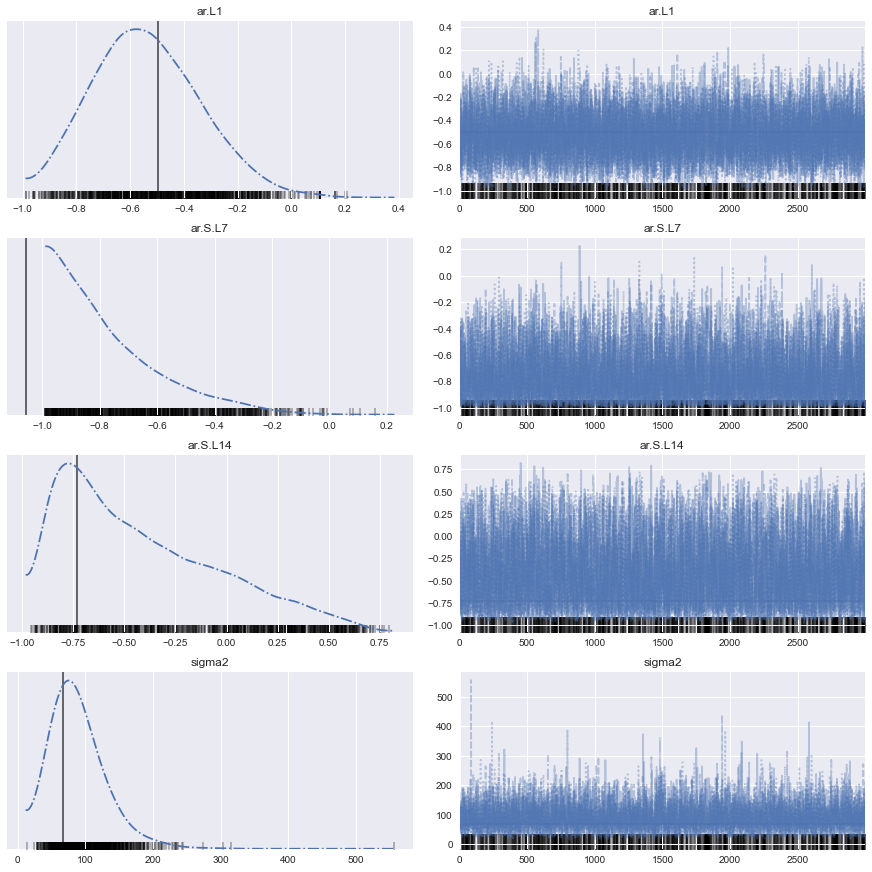

In [100]:
plt.tight_layout()
# Note: the syntax here for the lines argument is required for
# PyMC3 versions >= 3.7
# For version <= 3.6 you can use lines=dict(res_mle.params) instead
_ = pm.traceplot(trace,
                 lines=[(k, {}, [v]) for k, v in dict(fit4.params).items()],
                 combined=True,
                 figsize=(12, 12))

### Application of Bayesian estimates of parameters

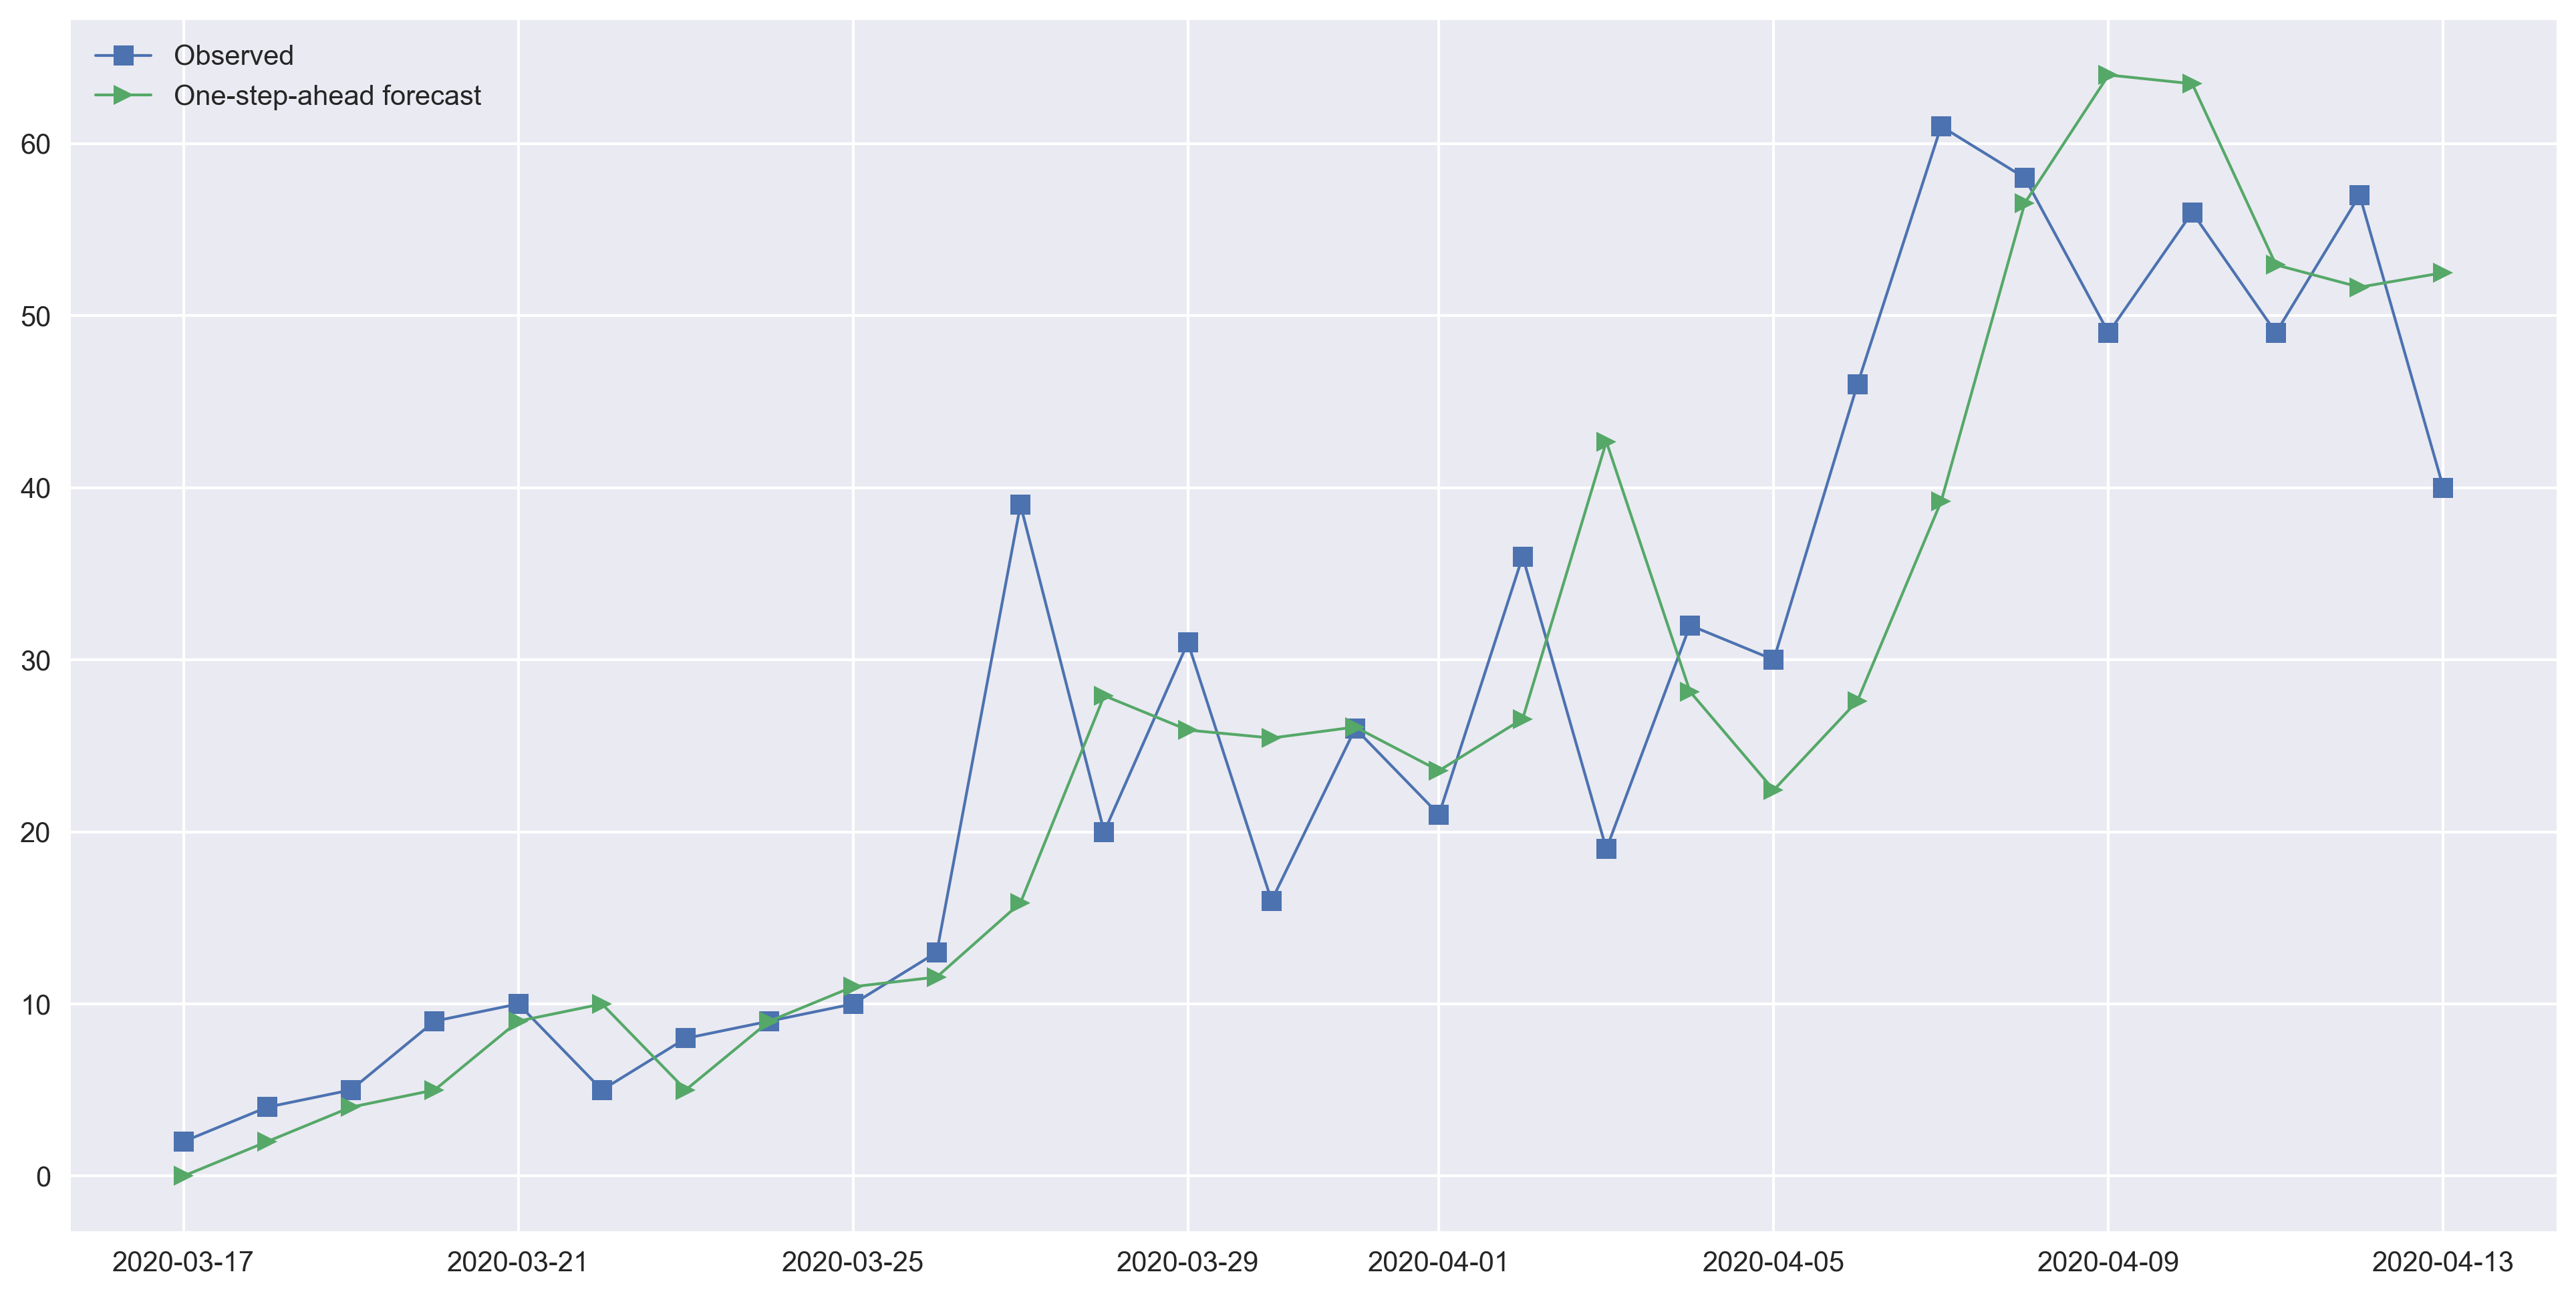

In [144]:
# Retrieve the posterior medians
params = [np.percentile(trace[param], 50, axis=0) for param in model.param_names]

# Construct results using these posterior means as parameter values
res_bayes = model.smooth(params)

predict_bayes = res_bayes.get_prediction()
predict_bayes_ci = predict_bayes.conf_int()
lower = predict_bayes_ci['lower new_cases']
upper = predict_bayes_ci['upper new_cases']

# Graph
fig, ax = plt.subplots(figsize=(16,8), dpi=300)

# Plot data points
plt.plot(df_train.index, df_train['new_cases'], marker='s', ls='-', lw=1, label='Observed')

# Plot predictions
plt.plot(df_train.index, predict_bayes.predicted_mean, 
        marker='>', ls='-', lw=1, label='One-step-ahead forecast')
# ax.fill_between(predict_bayes_ci.index, lower, upper, color='r', alpha=0.1)
ax.legend(loc='upper left')
plt.show()

In [128]:
res_bayes.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         new_cases   No. Observations:                   28
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 7)   Log Likelihood                 -78.293
Date:                           Sun, 19 Apr 2020   AIC                            164.586
Time:                                   08:46:55   BIC                            168.569
Sample:                               03-17-2020   HQIC                           165.363
                                    - 04-13-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5521      0.212     -2.605      0.009      -0.967      -0.137
ar.S.L7       -0.8260      0.690     -1.197      0.231      -2.178       0.526
ar.S.L14      -0.5117      1.103     -0.464      0.643      -2.674       1.650
sigma2        82.5243    127.740      0.646      0.518    -167.841     332.890
===================================================================================
Ljung-Box (Q):                       15.75   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.67   Prob(JB):                         0.95
Heteroskedasticity (H):               2.30   Skew:                             0.01
Prob(H) (two-sided):                  0.29   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [129]:
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         new_cases   No. Observations:                   28
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 7)   Log Likelihood                 -77.599
Date:                           Sun, 19 Apr 2020   AIC                            163.197
Time:                                   08:47:13   BIC                            167.180
Sample:                               03-17-2020   HQIC                           163.975
                                    - 04-13-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4946      0.247     -2.003      0.045      -0.978      -0.011
ar.S.L7       -1.0582      0.332     -3.184      0.001      -1.709      -0.407
ar.S.L14      -0.7308      0.602     -1.213      0.225      -1.911       0.450
sigma2        67.2789    115.660      0.582      0.561    -159.410     293.968
===================================================================================
Ljung-Box (Q):                       14.36   Jarque-Bera (JB):                 0.43
Prob(Q):                              0.76   Prob(JB):                         0.81
Heteroskedasticity (H):               2.88   Skew:                            -0.01
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Prediction plot of the bayesian model (SARIMAX with bayesian parameters estimation)

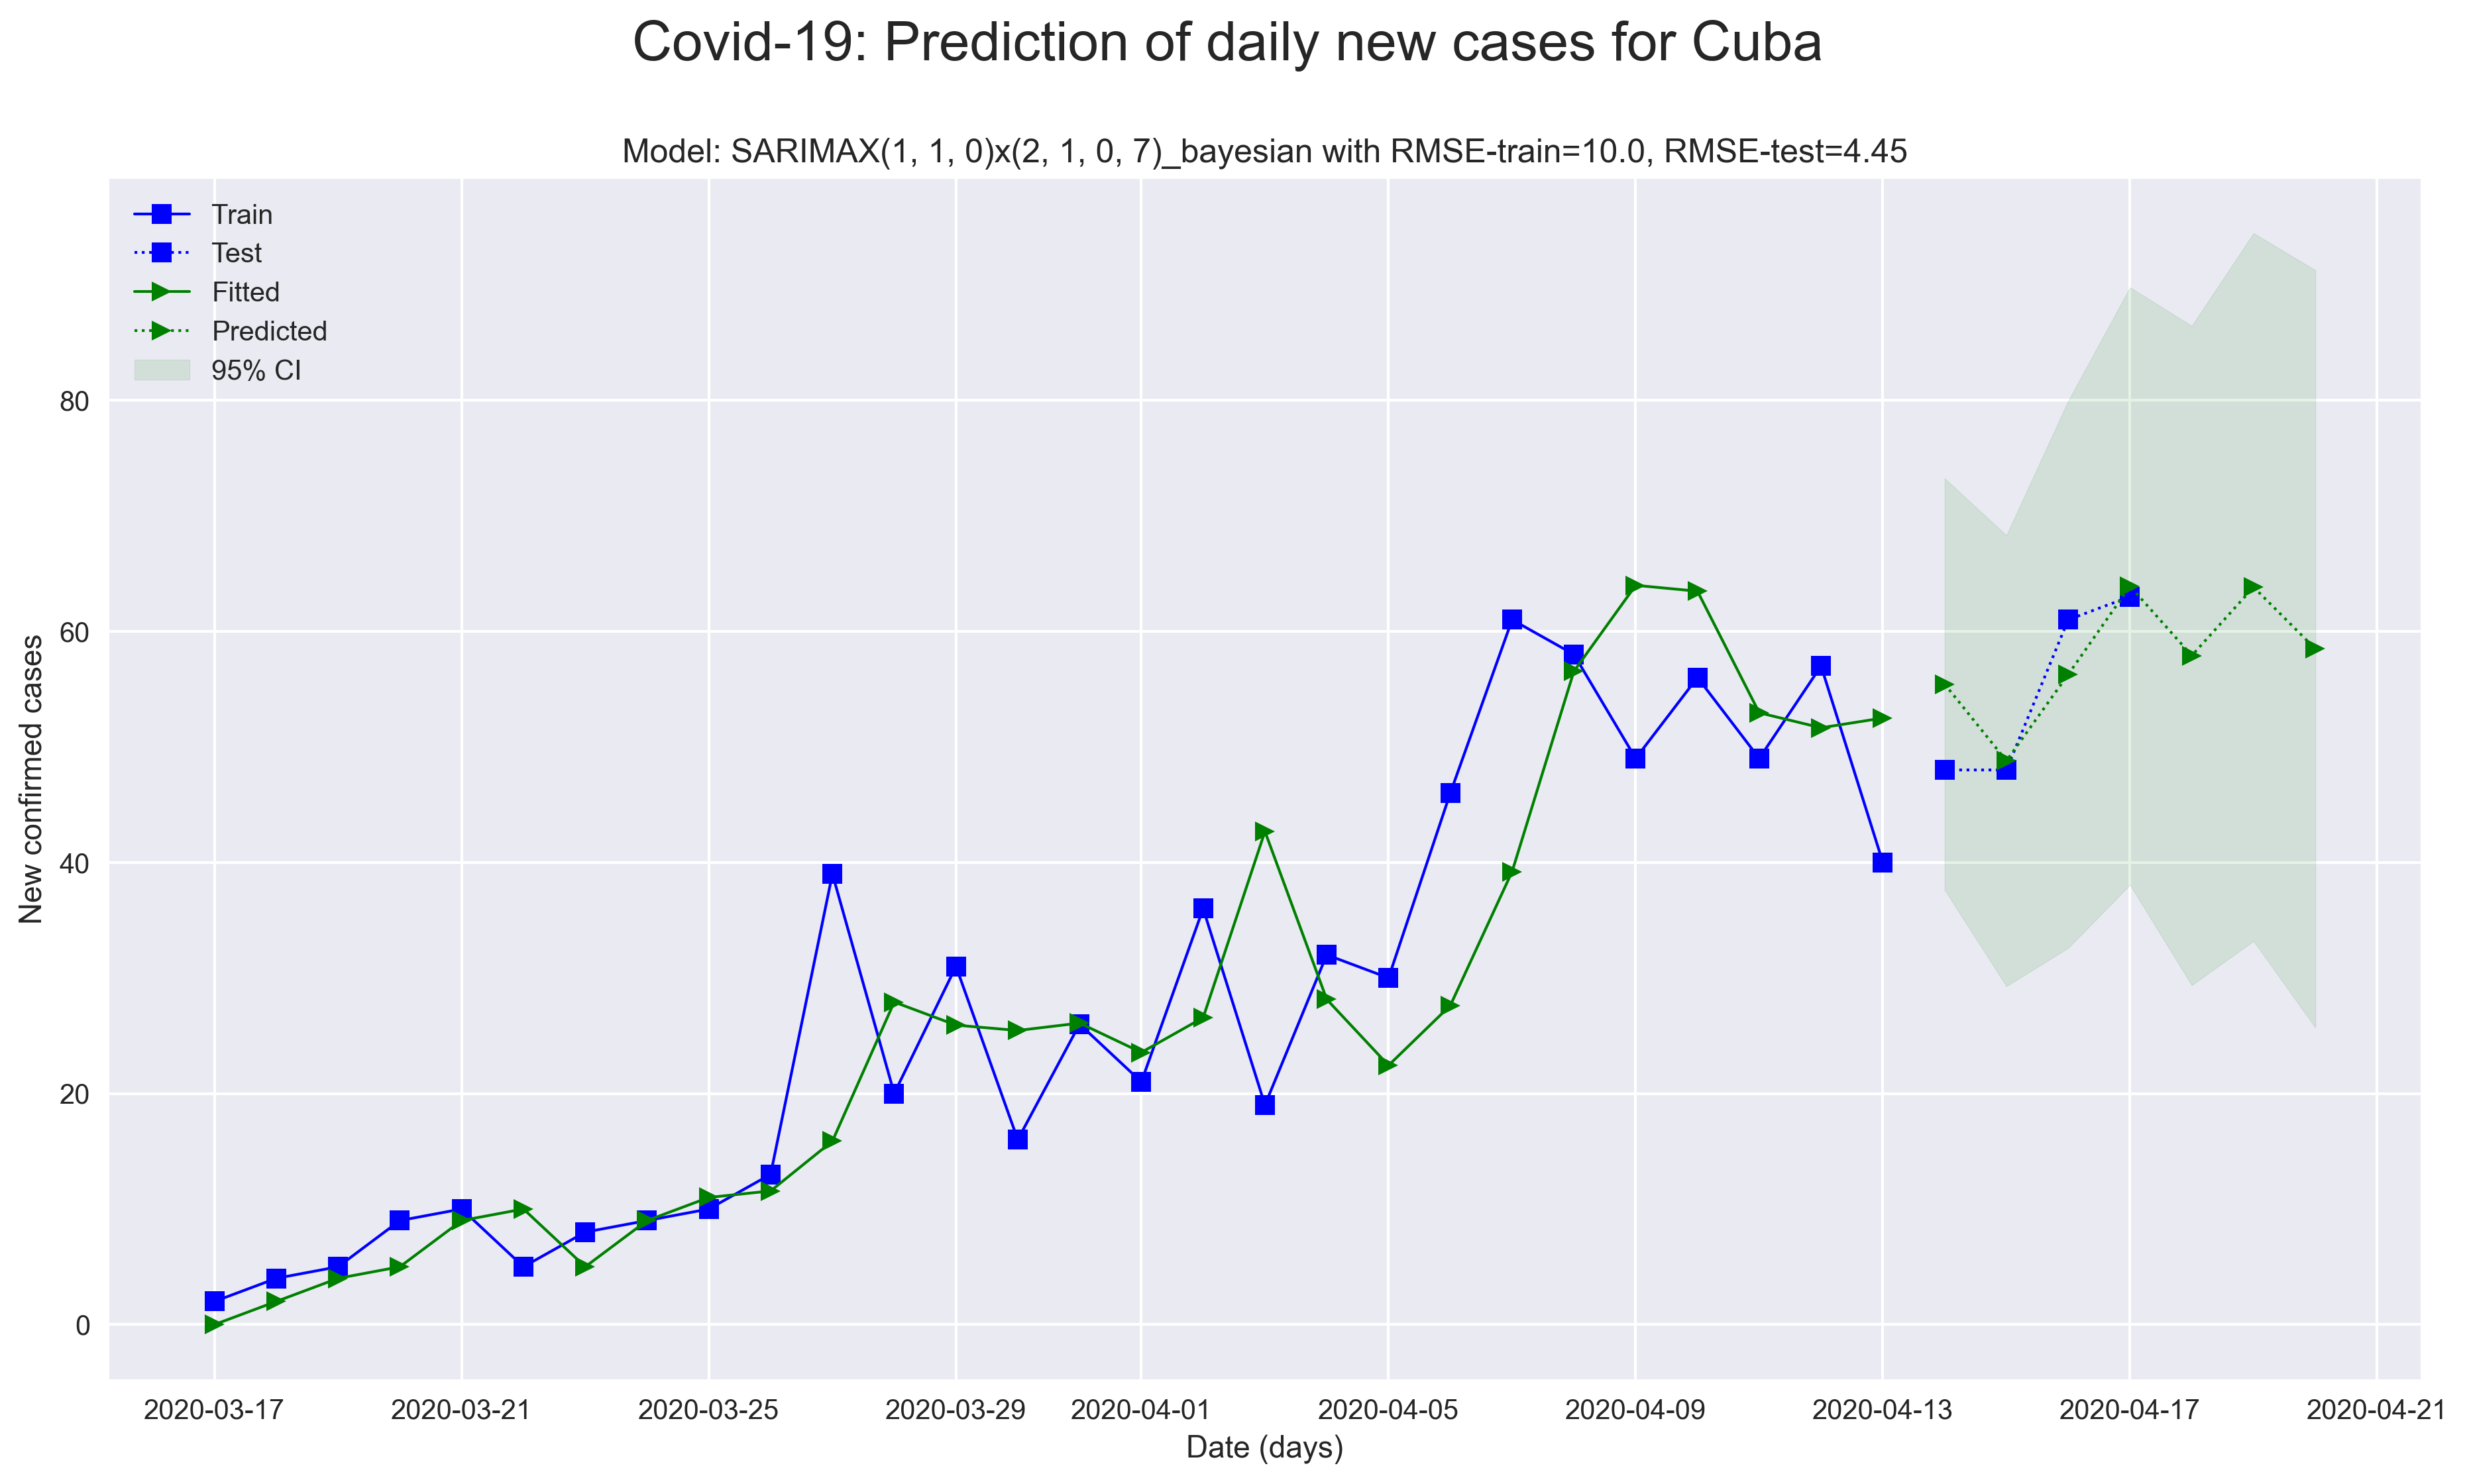

In [130]:
# Fitted values
fitted_bayes = res_bayes.get_prediction()
fitted = fitted_bayes.predicted_mean

# Construct the forecasts
fcast_bayes = res_bayes.get_forecast(steps=7).summary_frame()
model_name = str(res_bayes.summary().tables[0].data[1][1]) + '_bayesian'
rms_train = round(np.sqrt(mean_squared_error(df_train[ylab], fitted)),2)
rms_test = round(np.sqrt(mean_squared_error(df_test[ylab], fcast_bayes['mean'][:len(df_test)])),2)

# Plot the forecasts
plt.figure(figsize=(15, 8), dpi=300)
plt.plot(df_train.index, df_train['new_cases'], 'b', marker='s', ls='-', lw=1, label='Train')
plt.plot(df_test.index, df_test['new_cases'], 'b', marker='s', ls=':', lw=1, label='Test')
plt.plot(df_train.index, fitted, 'g', marker='>', ls='-', lw=1, label='Fitted')
plt.plot(fcast_bayes.index,fcast_bayes['mean'], 'g',marker='>', ls=':', lw=1, label='Predicted')
plt.fill_between(fcast_bayes.index, fcast_bayes['mean_ci_lower'], fcast_bayes['mean_ci_upper'], color='g', alpha=0.1, label='95% CI')
plt.suptitle('Covid-19: Prediction of daily new cases for {}'.format(country), fontsize=20)
plt.title('Model: {} with RMSE-train={}, RMSE-test={}'.format(model_name,rms_train,rms_test))
plt.xlabel('Date (days)')
plt.ylabel('New confirmed cases')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [133]:
fcast_bayes['real'] = df_test['new_cases']
fcast_bayes

new_cases,mean,mean_se,mean_ci_lower,mean_ci_upper,real
2020-04-14,55.432021,9.084287,37.627145,73.236897,48.0
2020-04-15,48.789581,9.954066,29.279969,68.299192,48.0
2020-04-16,56.265845,12.076395,32.596545,79.935145,61.0
2020-04-17,63.905058,13.192030,38.049155,89.760961,63.0
2020-04-18,57.900209,14.556492,29.370009,86.430410,NaN
2020-04-19,63.823092,15.628118,33.192544,94.453641,NaN
2020-04-20,58.475600,16.720517,25.703988,91.247212,NaN
